In [1]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
import astropy
import gammapy
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs
gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator, LightCurveEstimator, ESTIMATOR_REGISTRY
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

#print(MODEL_REGISTRY)

CPU times: user 2.7 s, sys: 1.06 s, total: 3.75 s
Wall time: 5.61 s


In [5]:
time = 57334.085794
time_ref = 53402

time_second = (time - time_ref)*3600*24
print(time_second)

339732212.6015999


In [6]:
source = "Boomerang"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")
obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")
hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str38
74347,events,events,74347.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/Boomerang
74347,gti,gti,74347.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/Boomerang
74347,aeff,aeff_2d,74347.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/Boomerang
74347,edisp,edisp_2d,74347.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/Boomerang
74347,psf,psf_table,74347.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/Boomerang
74347,bkg,bkg_2d,74347.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/Boomerang
74349,events,events,74349.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/Boomerang
74349,gti,gti,74349.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/Boomerang
74349,aeff,aeff_2d,74349.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/Boomerang


In [7]:
data_store.obs_table
data_store.hdu_table = hdu_table

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]



# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)
print(len(observations))

309


In [8]:
for obs in observations:
    print(obs.gti)
    print(obs.gti.time_ref)
    break
event = EventList.read("/Users/cedrickperron/GAMMAPY/Boomerang/74347.anasum.fits")
event.time_ref
event.time



GTI info:
- Number of GTIs: 1
- Duration: 1801.829987347126 s
- Start: 56930.23679011541 MET
- Start: 2014-09-30T05:40:58.666 (time standard: UTC)
- Stop: 56930.25764462915 MET
- Stop: 2014-09-30T06:11:00.496 (time standard: UTC)

53402.0


<Time object: scale='utc' format='mjd' value=[56930.47358812 56930.47359673 56930.4736053  ... 56930.49439359
 56930.49440818 56930.49442382]>

In [21]:
target_position = SkyCoord(ra="22h28m44s", dec="61d10m00s", frame="icrs")

#help(SkyCoord)
print(target_position)
# anasum.log ==> theta2 cut: 0.008 deg2
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)

<SkyCoord (ICRS): (ra, dec) in deg
    (337.18333333, 61.16666667)>


In [22]:
# The binning of the final spectrum is defined here.
energy_axis = MapAxis.from_energy_bounds(0.1, 40.0, 10, unit="TeV", name="energy")

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, 30, unit="TeV", name="energy_true"
)

# Here we use 1.5 degree which is slightly larger than needed.
geom = WcsGeom.create(skydir=target_position, binsz=0.01, width=(10,10), proj="CAR",axes=[energy_axis])

geom_image = geom.to_image()

# LS5039 Region
#LS5039_region = CircleSkyRegion(center=center1, radius=0.25* u.deg)


center_region = CircleSkyRegion(center=target_position, radius=0.35* u.deg)

exclusion_mask=Map.from_geom(geom_image)
exclusion_mask.data=geom_image.region_mask([center_region], inside=False)
# No pixel => Energy => 0 (no signal)
#exclusion_mask.sum_over_axes().plot(add_cbar=True)

In [23]:
maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf"])

#maker = MapDatasetMaker(selection=["counts", "exposure", "psf"])

In [24]:

#Create an empty 1D SpectrumDataset: Note here we don't have a background model, thus we can only define a SpectrumDataset background
e_reco = energy_axis
e_true = energy_axis_true
#Create an empty dataset that you will use for each observation
dataset_empty = SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region)

# Create the DatasetMaker
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "psf", "edisp"])
# Create the Background Maker
#help(ReflectedRegionsBackgroundMaker)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask, max_region_number=6)
bkg_maker_none = ReflectedRegionsBackgroundMaker(exclusion_mask=None, max_region_number=6)
#Create a Safe_mask_maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=2.5*u.deg)


# Create a stacked dataset
#stacked = SpectrumDatasetOnOff.create(e_reco=e_reco,  e_true=e_true, region=on_region)
#help(dataset.to_spectrum_dataset)

for i, obs in enumerate(observations):
    if obs.obs_id == 96491:
        print(i)


297


In [ ]:
count = 0
for obs in observations[85:]:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    print(count)
    print(dataset)
    count += 1

0
SpectrumDataset
---------------

  Name                            : JdQMx0iK 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.13e-04 m2 s
  Exposure max                    : 3.26e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


1
SpectrumDataset
---------------

  Name                            : qkrsLDC_ 

  Total counts                    : 6 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted ex

12
SpectrumDataset
---------------

  Name                            : SlICXZzg 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.62e-05 m2 s
  Exposure max                    : 3.19e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


13
SpectrumDataset
---------------

  Name                            : BG0xHk7S 

  Total counts                    : 4 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted 

24
SpectrumDataset
---------------

  Name                            : YdUGLokJ 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.22e-02 m2 s
  Exposure max                    : 4.89e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


25
SpectrumDataset
---------------

  Name                            : YUt5H8wx 

  Total counts                    : 11 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted

36
SpectrumDataset
---------------

  Name                            : _BnBDK_h 

  Total counts                    : 8 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.51e-03 m2 s
  Exposure max                    : 8.04e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


37
SpectrumDataset
---------------

  Name                            : Q3SH4pQx 

  Total counts                    : 0 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted 

48
SpectrumDataset
---------------

  Name                            : xp0EeOXo 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.23e-01 m2 s
  Exposure max                    : 6.68e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


49
SpectrumDataset
---------------

  Name                            : Av2aDM3i 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted 

60
SpectrumDataset
---------------

  Name                            : _RzK1Kni 

  Total counts                    : 4 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.66e-01 m2 s
  Exposure max                    : 3.41e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


61
SpectrumDataset
---------------

  Name                            : 3sOogiTs 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted 

72
SpectrumDataset
---------------

  Name                            : aySU_u8x 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.02e-02 m2 s
  Exposure max                    : 5.97e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


73
SpectrumDataset
---------------

  Name                            : MLEyrE6_ 

  Total counts                    : 4 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted 

84
SpectrumDataset
---------------

  Name                            : kgn1zXyO 

  Total counts                    : 1 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.75e-02 m2 s
  Exposure max                    : 4.91e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


85
SpectrumDataset
---------------

  Name                            : 1ThlXYnE 

  Total counts                    : 4 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted 

96
SpectrumDataset
---------------

  Name                            : kduPAkRS 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.15e-02 m2 s
  Exposure max                    : 5.18e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


97
SpectrumDataset
---------------

  Name                            : bh-3Y9wv 

  Total counts                    : 6 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted 

108
SpectrumDataset
---------------

  Name                            : 3xZFD494 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.63e-06 m2 s
  Exposure max                    : 1.80e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


109
SpectrumDataset
---------------

  Name                            : VL-X4fNw 

  Total counts                    : 2 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

120
SpectrumDataset
---------------

  Name                            : qKFmLrJr 

  Total counts                    : 0 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.13e-04 m2 s
  Exposure max                    : 1.44e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


121
SpectrumDataset
---------------

  Name                            : ozaL7Du7 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

132
SpectrumDataset
---------------

  Name                            : KiKk375s 

  Total counts                    : 4 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.37e-09 m2 s
  Exposure max                    : 1.92e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


133
SpectrumDataset
---------------

  Name                            : EtFUmlNA 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

144
SpectrumDataset
---------------

  Name                            : 9C2ZmDZs 

  Total counts                    : 4 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.03e-02 m2 s
  Exposure max                    : 5.95e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


145
SpectrumDataset
---------------

  Name                            : RbSd-fio 

  Total counts                    : 2 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

156
SpectrumDataset
---------------

  Name                            : Jo58wygD 

  Total counts                    : 1 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.69e-01 m2 s
  Exposure max                    : 3.31e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


157
SpectrumDataset
---------------

  Name                            : mVuEb8oW 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

168
SpectrumDataset
---------------

  Name                            : 9hF4q3m7 

  Total counts                    : 1 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.07e-01 m2 s
  Exposure max                    : 2.11e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


169
SpectrumDataset
---------------

  Name                            : LtbGejG0 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

180
SpectrumDataset
---------------

  Name                            : cGcD2YfZ 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.66e-04 m2 s
  Exposure max                    : 5.22e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


181
SpectrumDataset
---------------

  Name                            : dHwqSLq7 

  Total counts                    : 4 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

192
SpectrumDataset
---------------

  Name                            : yPFs7_Hn 

  Total counts                    : 5 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.04e-02 m2 s
  Exposure max                    : 5.44e+08 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


193
SpectrumDataset
---------------

  Name                            : 8wJm3iNa 

  Total counts                    : 3 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicte

In [14]:
%%time
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="Boomerang"
)

empty_dataset = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="Boomerang"
)

datasets = Datasets()
count = 0
for obs in observations:
    # A MapDataset is filled in this geometry
    dataset = maker.run(empty_dataset.copy(name=f"{obs.obs_id}"), obs)
    # To make images, the resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)
    
        
    # Extract 1D spectrum
    spectrum_dataset = dataset.to_spectrum_dataset(
        on_region, containment_correction= True, name=f"obs-{obs.obs_id}"
    )
    # Compute OFF
    if (count == 255) or (count == 298):
        spectrum_dataset = bkg_maker_none.run(spectrum_dataset, obs)
    else:
        spectrum_dataset = bkg_maker.run(spectrum_dataset, obs)
    # Define safe mask
    spectrum_dataset = safe_mask_maker.run(spectrum_dataset, obs)
    # Append dataset to the list
    print(spectrum_dataset)
    datasets.append(spectrum_dataset)
    count += 1

SpectrumDatasetOnOff
--------------------

  Name                            : obs-74347 

  Total counts                    : 7 
  Total off counts                : 26.00
  Total background counts         : 4.33
  Total excess counts             : 2.67

  Predicted counts                : 4.71
  Predicted background counts     : 4.71
  Predicted excess counts         : nan

  Exposure min                    : 2.84e-04 m2 s
  Exposure max                    : 1.60e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 60.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : obs-74349 

  Total counts                    : 9 
  Total off counts     

SpectrumDatasetOnOff
--------------------

  Name                            : obs-74581 

  Total counts                    : 9 
  Total off counts                : 37.00
  Total background counts         : 6.17
  Total excess counts             : 2.83

  Predicted counts                : 6.57
  Predicted background counts     : 6.57
  Predicted excess counts         : nan

  Exposure min                    : 5.40e-05 m2 s
  Exposure max                    : 5.72e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 60.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.79

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : obs-74604 

  Total counts                    : 6 
  Total off counts     

SpectrumDatasetOnOff
--------------------

  Name                            : obs-74651 

  Total counts                    : 7 
  Total off counts                : 58.00
  Total background counts         : 9.67
  Total excess counts             : -2.67

  Predicted counts                : 9.29
  Predicted background counts     : 9.29
  Predicted excess counts         : nan

  Exposure min                    : 8.18e-04 m2 s
  Exposure max                    : 2.91e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 60.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.57

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : obs-74667 

  Total counts                    : 3 
  Total off counts    

SpectrumDatasetOnOff
--------------------

  Name                            : obs-82799 

  Total counts                    : 1 
  Total off counts                : 5.00
  Total background counts         : 0.83
  Total excess counts             : 0.17

  Predicted counts                : 0.86
  Predicted background counts     : 0.86
  Predicted excess counts         : nan

  Exposure min                    : 3.76e-02 m2 s
  Exposure max                    : 4.56e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 60.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : obs-82994 

  Total counts                    : 3 
  Total off counts      

KeyboardInterrupt: 

In [15]:
datasets.meta_table

NAME,TYPE,TELESCOP,OBS_ID,RA_PNT,DEC_PNT
,,,,deg,deg
str9,str20,str7,int64,float64,float64
obs-74347,SpectrumDatasetOnOff,VERITAS,74347,337.08978271484375,60.125
obs-74349,SpectrumDatasetOnOff,VERITAS,74349,337.7887878417969,60.80838394165039
obs-74541,SpectrumDatasetOnOff,VERITAS,74541,336.9452819824219,60.16226577758789
obs-74542,SpectrumDatasetOnOff,VERITAS,74542,337.653076171875,60.8337287902832
obs-74543,SpectrumDatasetOnOff,VERITAS,74543,336.2584228515625,60.83429718017578
obs-74558,SpectrumDatasetOnOff,VERITAS,74558,337.00579833984375,61.582305908203125
obs-74559,SpectrumDatasetOnOff,VERITAS,74559,336.9053955078125,60.11594772338867
obs-74560,SpectrumDatasetOnOff,VERITAS,74560,337.6329650878906,60.84391403198242


In [ ]:
datasets.info_table(cumulative=False)

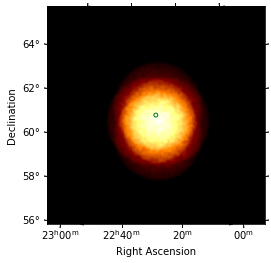

In [64]:
stacked.counts.sum_over_axes().smooth(width="0.05 deg").plot()
on_region.to_pixel(stacked.counts.geom.wcs).plot()

In [73]:
stacked.counts.smooth(0.05 * u.deg).plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [74]:
"""
excess = stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);
"""

'\nexcess = stacked.excess.sum_over_axes()\nexcess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);\n'

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe726468198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe726b25160>)

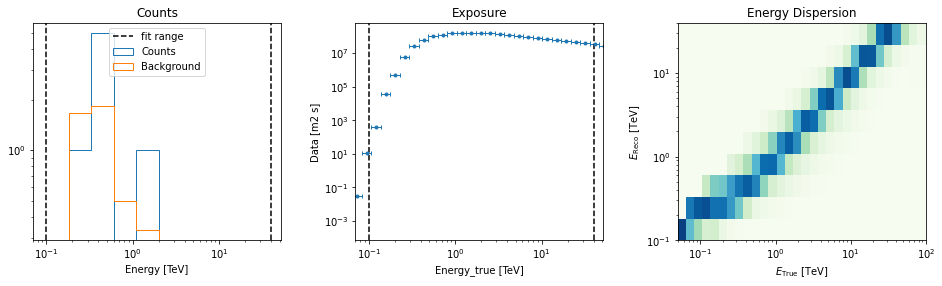

In [42]:
datasets[0].peek()

In [43]:
info_table = datasets.info_table(cumulative=True)

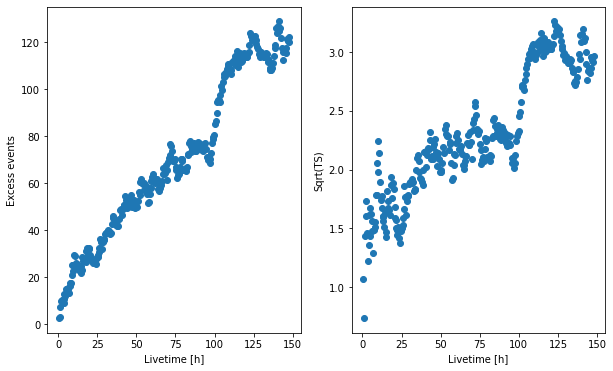

In [44]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121)
ax.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess events")

ax = fig.add_subplot(122)
ax.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

In [45]:
spectral_model = PowerLawSpectralModel(
    index=2.50, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
sky_model = SkyModel(spectral_model=spectral_model, name="HESS J1826-148")

#datasets.models = Models([sky_model])

for dataset in datasets:
    dataset.models = sky_model

In [46]:
%%time
fit_joint = Fit(datasets)
result_joint = fit_joint.run()
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 268
	total stat : 1376.57

CPU times: user 7min 11s, sys: 4.95 s, total: 7min 16s
Wall time: 7min 30s


In [47]:
result_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,4.4876e+00,,nan,nan,False,1.378e+00
amplitude,8.8329e-15,cm-2 s-1 TeV-1,nan,nan,False,1.287e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


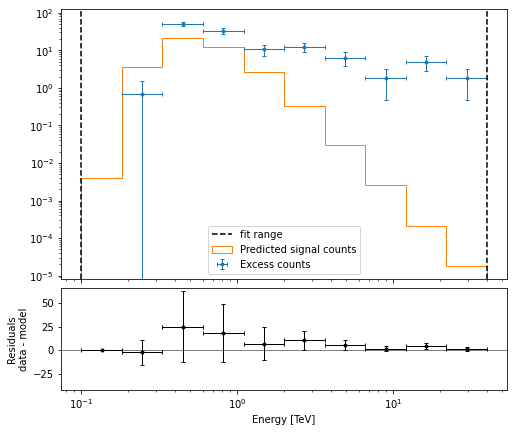

In [49]:
# First stack them all
reduced = datasets.stack_reduce()
# Assign the fitted model
reduced.models = sky_model
# Plot the result
reduced.plot_fit();